In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from sympy import *

System Class:

In [2]:
class System:
  def __init__(self, particles, constraints, forces):
   self.__particles = particles
   self.__constraints = constraints
   self.__forces = forces
   self.__J = None
   self.__J_eval = None
   self.__J_dot = None
   self.__J_dot_eval = None
   self.__C_eval = None
   self.__C_dot = None
   self.__C_dot_eval = None
   self.__vel_mat = None
   self.__pos_mat = None
   self.initPosMat()
   self.initVelMat()

  def getParticles(self):
    return self.__particles

  def evaluate(self, expression_str):
    expression = sympify(expression_str)

    for i in range(0, len(self.__particles)):
      x = symbols(self.__particles[i].getSym()[0])
      y = symbols(self.__particles[i].getSym()[1])
      expression = expression.subs(x, round(self.__particles[i].getPos()[0],4))
      expression = expression.subs(y, round(self.__particles[i].getPos()[1],4))

    #print(round(Float(str(expression)), 4))
    return round(Float(str(expression)), 4)

  def getDerivative(self, expression_str, symbol):
    expression = sympify(expression_str)
    x = symbols(symbol)
    return expression.diff(x)

  def setJacobian(self):
    J = [["" for x in range(len(self.__particles)*2)] for y in range(len(self.__constraints))]

    for i in range(0,len(self.__constraints)):
      for j in range(0,len(self.__particles)):
        J[i][2*j] = str(self.getDerivative(self.__constraints[i].getConstraint(), self.__particles[j].getSym()[0]))
        J[i][2*j+1] = str(self.getDerivative(self.__constraints[i].getConstraint(), self.__particles[j].getSym()[1]))
    
    self.__J = J
    
    #print("Jacobian: \n")
    #print(self.__J)

  def setJacobianDot(self):
    if self.__J is None:
      self.setJacobian()

    J_dot = [["" for x in range(len(self.__particles)*2)] for y in range(len(self.__constraints))]

    for i in range(0,len(self.__constraints)):
      for j in range(0,len(self.__particles)):
        stringBuilder_x = ""
        stringBuilder_y = ""
        for k in range(0, len(self.__particles)):
          if k is not 0:
            stringBuilder_x +="+"  
          stringBuilder_x += "("
          stringBuilder_x += str(self.getDerivative(self.__J[i][2*j], self.__particles[k].getSym()[0])*round(self.__particles[k].getVel()[0],4))
          stringBuilder_x += ")"
          if k is not 0:
            stringBuilder_y += "+"  
          stringBuilder_y += "("
          stringBuilder_y += str(self.getDerivative(self.__J[i][2*j+1], self.__particles[k].getSym()[1])*round(self.__particles[k].getVel()[1],4))
          stringBuilder_y += ")"
        
        J_dot[i][2*j] = str(stringBuilder_x)
        J_dot[i][2*j+1] = str(stringBuilder_y)
    
    self.__J_dot = J_dot

    #print("Jacobian_dot: \n")
    #print(self.__J_dot)

  def setConstraintsDot(self):
    self.setJacobian()

    C_dot = []

    for i in range(0, len(self.__constraints)):
      stringBuilder = ""
      for j in range(0, len(self.__particles)):
        if j is not 0:
          stringBuilder += "+"
        stringBuilder += "("
        stringBuilder += str(sympify(self.__J[i][2*j])*round(self.__particles[j].getVel()[0],4))
        stringBuilder += ")+" 
        stringBuilder += "("
        stringBuilder += str(sympify(self.__J[i][2*j+1])*round(self.__particles[j].getVel()[1], 4))
        stringBuilder += ")" 

      C_dot.append(stringBuilder)

    self.__C_dot = C_dot
    
    #print("C_dot: \n")
    #print(self.__C_dot)

  def evalJacobian(self):
    if self.__J is None:
      self.setJacobian()

    J_eval = np.zeros((len(self.__constraints), len(self.__particles)*2))

    for i in range(0,len(self.__constraints)):
      for j in range(0,len(self.__particles)*2):
        J_eval[i][j] = round(self.evaluate(self.__J[i][j]),4)
    
    self.__J_eval = J_eval
    
    #print("Jacobian value: \n")
    #print(self.__J_eval)

    return self.__J_eval

  def evalJacobianDot(self):
    self.setJacobianDot()

    J_dot_eval = np.zeros((len(self.__constraints), len(self.__particles)*2))

    for i in range(0,len(self.__constraints)):
      for j in range(0,len(self.__particles)*2):
        J_dot_eval[i][j] = round(self.evaluate(self.__J_dot[i][j]),4)
    
    self.__J_dot_eval = J_dot_eval

    #print("Jacobian_dot value: \n")
    #print(self.__J_dot_eval)

    return self.__J_dot_eval

  def evalConstraints(self):
    assert(self.__constraints is not None)

    C_eval = np.zeros((len(self.__constraints)))

    for i in range(0, len(self.__constraints)):
      C_eval[i] = round(self.evaluate(self.__constraints[i].getConstraint()),4)
    
    self.__C_eval = C_eval
    
    #print("C_eval: \n")
    #print(self.__C_eval)

    return self.__C_eval

  def evalConstraintsDot(self):
    self.setConstraintsDot()

    C_dot_eval = np.zeros((len(self.__constraints)))

    for i in range(0, len(self.__constraints)):
      C_dot_eval[i] = round(self.evaluate(self.__C_dot[i]),4)
    
    self.__C_dot_eval = C_dot_eval
    
    #print("C_dot_eval: \n")
    #print(self.__C_dot_eval)

    return self.__C_dot_eval
  
  def initVelMat(self):
    vel_mat = np.empty((len(self.__particles)*2))

    for i in range(0, len(self.__particles)):
      vel_mat[i*2] = self.__particles[i].getVel()[0]
      vel_mat[i*2+1] = self.__particles[i].getVel()[1]
    
    self.__vel_mat = vel_mat

    #print("Velocity matrix: \n")
    #print(self.__vel_mat)
  
  def initPosMat(self):
    pos_mat = np.empty((len(self.__particles)*2))

    for i in range(0, len(self.__particles)):
      pos_mat[i*2] = self.__particles[i].getPos()[0]
      pos_mat[i*2+1] = self.__particles[i].getPos()[1]
    
    self.__pos_mat = pos_mat

    #print("Position Matrix: \n")
    #print(self.__pos_mat)

  def getVelMat(self):
    return self.__vel_mat
  
  def getPosMat(self):
    return self.__pos_mat

  def setVelMat(self, vel_mat):
    self.__vel_mat = vel_mat
    for i in range(0, len(self.__particles)):
      self.__particles[i].setVel(round(self.__vel_mat[2*i],4), round(self.__vel_mat[2*i+1],4))

  def setPosMat(self, pos_mat):
    #print("-------")
    self.__pos_mat = pos_mat
    for i in range(0, len(self.__particles)):
      self.__particles[i].setPos(round(self.__pos_mat[2*i],4), round(self.__pos_mat[2*i+1],4))
      #print(str(self.__pos_mat[2*i])+" "+str(self.__pos_mat[2*i+1]))
    #print("-------")

Particle and Constraint Classes

In [3]:
class Particle:
  def __init__(self, position, velocity, symbols):
    self.__position = position
    self.__velocity = velocity
    self.__symbols = symbols

  def getPos(self):
    return self.__position
  
  def getVel(self):
    return self.__velocity

  def getSym(self):
    return self.__symbols

  def setPos(self, x, y):
    self.__position[0] = x
    self.__position[1] = y

  def setVel(self, vx, vy):
    self.__velocity[0] = vx
    self.__velocity[1] = vy

  def setSym(self, x, y):
    self.__symbols[0] = x
    self.__symbols[1] = y

class Constraint:
  def __init__(self, constraint):
    self.__constraint = constraint
  
  def getConstraint(self):
    return self.__constraint


Initialization

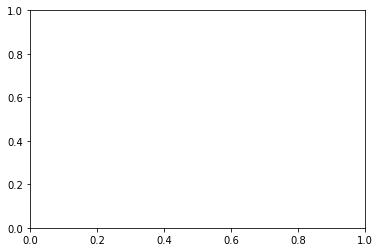

In [4]:
system = None
beads = []
fig, ax = plt.subplots()

In [5]:
def initialize():

  global system
  
  particles = []
  constraints = []
  forces = []


  p1 = Particle(np.array([0.0, 0.0]), np.array([0.0, 0.0]),np.array(['x1', 'y1']))
  p2 = Particle(np.array([4.0, 2.308]), np.array([0.0, 0.0]),np.array(['x2', 'y2']))
  p3 = Particle(np.array([-4.0, 2.308]), np.array([0.0, 0.0]),np.array(['x3', 'y3']))

  particles.append(p1)
  particles.append(p2)
  particles.append(p3)

  c1 = Constraint("0.5*(x2-x1)**2 + 0.5*(y2-y1)**2 - 10.663432")
  #c2 = Constraint("0.5*(x3-x2)**2 + 0.5*(y3-y2)**2 - 32.0")
  c3 = Constraint("0.5*(x3-x1)**2 + 0.5*(y3-y1)**2 - 10.663432")
  c4 = Constraint("0.5*x1")
  c5 = Constraint("0.5*y2-0.5*0.577*x2")
  c6 = Constraint("0.5*y3+0.5*0.577*x3")

  constraints.append(c1)
  #constraints.append(c2)
  constraints.append(c3)
  constraints.append(c4)
  constraints.append(c5)
  constraints.append(c6)
  
  ax.set_xlim((-6.0, 6.0))
  ax.set_ylim((-4.0, 4.0))

  """p1 = Particle(np.array([0.6, 0.8]), np.array([0.0, 0.0]),np.array(['x1', 'y1']))
  p2 = Particle(np.array([0.6, 0.3]), np.array([0.0, 0.0]),np.array(['x2', 'y2']))

  particles.append(p1)
  particles.append(p2)

  c1 = Constraint("0.5*(x1)**2 + 0.5*(y1)**2 - 0.5")
  c2 = Constraint("0.5*(x1-x2)**2 + 0.5*(y1-y2)**2 - 0.125")

  constraints.append(c1)
  constraints.append(c2)

  ax.set_xlim((-3.0, 3.0))
  ax.set_ylim((-2.0, 2.0))"""

  f1 = np.array([0, -10, 0])

  forces = f1

  system = System(particles, constraints, forces)

  n = len(system.getParticles())

  for i in range(n):
    bead = plt.Circle((system.getParticles()[i].getPos()[0], system.getParticles()[i].getPos()[1]), 0.05, color='r')
    beads.append(bead)
    ax.add_artist(bead)


Numerical Integration: Midpoint method

In [6]:
def eval_derivative(positions, velocities):
  
  n = len(system.getParticles())
  M = np.eye(n * 2)
  W = np.eye(n * 2)  
  g = -10.0 
  Q = M @ np.tile([0.0, g], n).reshape(-1, 1)

  J = system.evalJacobian()
  Jdot = system.evalJacobianDot()
  C = system.evalConstraints().reshape(-1,1)
  Cdot = system.evalConstraintsDot().reshape(-1,1)

  print("C")
  print(C)
  #print("Cdot")
  #print(Cdot)
  print("J")
  print(J)
  #print("Jdot")
  #print(Jdot)

  positions = positions.reshape(-1, 1)
  velocities = velocities.reshape(-1, 1)
  positions_derivative = np.zeros(positions.shape)
  velocities_derivative = np.zeros(velocities.shape)

  ks = 2.0
  kd = 2.0

  rhs = J@W@J.T
  lhs = (-1*Jdot)@(velocities) - J@W@Q
  feedback =  ks*C + kd*Cdot
  l = (np.linalg.inv(rhs))@ lhs #- feedback
  Q_hat = J.T@l

  positions_derivative = velocities
  velocities_derivative = np.linalg.inv(M)@(Q_hat+Q)

  assert(positions_derivative.shape == positions.shape)
  assert(velocities_derivative.shape == velocities.shape)

  return positions_derivative.reshape(-1), velocities_derivative.reshape(-1)


def mid_point(dt):
  """Advances the positions and velocities by dt using the Midpoint method."""
  pos = system.getPosMat()
  vel = system.getVelMat()
  dp, dv = eval_derivative(pos, vel)
  mp = pos + dt * dp * 0.5
  mv = vel + dt * dv * 0.5
  system.setPosMat(mp)
  system.setVelMat(mv)
  dp, dv = eval_derivative(mp, mv)
  system.setPosMat(pos + dt * dp)
  system.setVelMat(vel + dt * dv)

def update(dt):
  mid_point(dt)


Frame Generation

In [ ]:
def init_animation():
  plot_scene()
  return []

def plot_scene():
  #circle.set_data(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)))
  circle1 = plt.Circle((0, 0), 1.0, color='black', fill=False)
  ax.add_artist(circle1)
  n = len(system.getParticles())
  for i in range(0,n-1):
    beads[i].set_center((system.getPosMat()[2*i], system.getPosMat()[2*i+1]))
    #rod.set_data([system.getParticles()[i].getPos()[0], system.getParticles()[i].getPos()[1]], [system.getParticles()[i+1].getPos()[0], system.getParticles()[i+1].getPos()[1]])

def animate(i):
  if i % 25 == 0:
    print("Generating frame #%d..." % i)
  update(0.01)
  plot_scene()
  return []

initialize()
anim = animation.FuncAnimation(fig, animate, init_func=init_animation, frames=500, interval=20, blit=False)
HTML(anim.to_html5_video())

Generating frame #0...
C
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
J
[[-4.         -2.30799866  4.          2.30799866  0.          0.        ]
 [ 4.         -2.30799866  0.          0.         -4.          2.30799866]
 [ 0.5         0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.28850174  0.5         0.          0.        ]
 [ 0.          0.          0.          0.          0.28850174  0.5       ]]
C
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
J
[[-4.         -2.30799866  4.          2.30799866  0.          0.        ]
 [ 4.         -2.30799866  0.          0.         -4.          2.30799866]
 [ 0.5         0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.28850174  0.5         0.          0.        ]
 [ 0.          0.          0.          0.          0.28850174  0.5       ]]
C
[[0.00010014]
 [0.00010014]
 [0.        ]
 [0.        ]
 [0.        ]]
J
[[-3.99980164 -2.3083992   3.99980164  2.3083992   0.          0.        ]
 [ 3.